# Vertical Farming

This project demonstrates the potential of time-series analysis to automate and optimize farming operations. By leveraging sensor data from a farming environment, the project successfully preprocessed and analyzed time-series data to create a robust dataset for training an RL agent. The Proximal Policy Optimization (PPO) algorithm was used to train the agent to make real-time decisions, such as maintaining optimal temperature and humidity levels, with the goal of balancing crop yield and resource consumption.

#### Dataset

The key columns in the dataset include:

- Cube ID: Likely an identifier for the sensor or location where the data was collected.
- Timestamp: The time at which the data was recorded (e.g., 2016-01-01 00:00:01).
- Temperature Layer A and Temperature Layer B: Temperature readings from two different layers (e.g., soil layers or greenhouse zones).
- Humidity Layer A and Humidity Layer B: Humidity readings from two different layers.
- Door: A binary or numeric value indicating the state of a door (e.g., open or closed).

In [1]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scipy.optimize import minimize

## 1. Load and Inspect Data

In [2]:
green = pd.read_csv('cubes.csv')
green.head()

C:\Users\milto\AppData\Local\Temp\ipykernel_58016\3519629084.py:1: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  green = pd.read_csv('cubes.csv')


,Unnamed: 0,Cube ID,Timestamp,Temperature Layer A,Temperature Layer B,Door,Humidity Layer A,Humidity Layer B
0,0,49,1451606401,NaN,NaN,0.0,NaN,NaN
1,1,95,1451606402,NaN,25.711898671792053°C,NaN,NaN,NaN
2,2,48,1451606402,NaN,NaN,NaN,NaN,NaN
3,3,55,1451606402,NaN,NaN,NaN,NaN,8.594411333817883g/m3
4,4,90,1451606403,NaN,NaN,NaN,NaN,NaN


In [3]:
print(green.info())
print(green.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400287 entries, 0 to 400286
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           400287 non-null  int64  
 1   Cube ID              400287 non-null  int64  
 2   Timestamp            400287 non-null  int64  
 3   Temperature Layer A  119236 non-null  object 
 4   Temperature Layer B  118080 non-null  object 
 5   Door                 5573 non-null    float64
 6   Humidity Layer A     4556 non-null    object 
 7   Humidity Layer B     4543 non-null    object 
dtypes: float64(1), int64(3), object(4)
memory usage: 24.4+ MB
None
          Unnamed: 0        Cube ID     Timestamp         Door
count  400287.000000  400287.000000  4.002870e+05  5573.000000
mean   200143.000000      49.561470  1.453763e+09     0.160237
std    115553.047939      28.989952  1.247102e+06     0.366858
min         0.000000       0.000000  1.451606e+09     0.0000

In [4]:
green.sample(5)

,Unnamed: 0,Cube ID,Timestamp,Temperature Layer A,Temperature Layer B,Door,Humidity Layer A,Humidity Layer B
90898,90898,27,1452583433,NaN,NaN,NaN,NaN,NaN
380322,380322,6,1455706931,21.032832384431625°C,NaN,NaN,NaN,NaN
342407,342407,30,1455296782,21.099539392458652°C,NaN,NaN,NaN,NaN
275861,275861,61,1454580142,NaN,26.75619939452413°C,NaN,NaN,NaN
107213,107213,72,1452758745,26.979701446182368°C,NaN,NaN,NaN,NaN


## 2. Clean Data

This includes: 

- Missing values: Some columns, such as the temperature and humidity layers, contain missing values (NaN). We should handle them by either filling or dropping them based on the context.
- Data type issues: The temperature and humidity values are stored as objects (strings) with units (e.g., "°C", "g/m3"), so they need to be converted to numeric values.
- Unnecessary columns: The Unnamed: 0 column seems to be an index column, so it can be dropped.
- Columns with few non-null values: The Door, Humidity Layer A, and Humidity Layer B columns contain very few non-null values. Depending on the context, we may decide to drop them or impute them.

In [5]:
# Drop the unnecessary 'Unnamed: 0' column
green.drop(columns=['Unnamed: 0'], inplace=True)

# Remove units from temperature and humidity columns
def remove_units(value):
    if isinstance(value, str):
        return value.replace('°C', '').replace('g/m3', '').strip()
    return value

# Apply the function to clean temperature and humidity columns
green['Temperature Layer A'] = green['Temperature Layer A'].apply(remove_units)
green['Temperature Layer B'] = green['Temperature Layer B'].apply(remove_units)
green['Humidity Layer A'] = green['Humidity Layer A'].apply(remove_units)
green['Humidity Layer B'] = green['Humidity Layer B'].apply(remove_units)

# Convert cleaned columns to numeric (float) type
green['Temperature Layer A'] = pd.to_numeric(green['Temperature Layer A'], errors='coerce')
green['Temperature Layer B'] = pd.to_numeric(green['Temperature Layer B'], errors='coerce')
green['Humidity Layer A'] = pd.to_numeric(green['Humidity Layer A'], errors='coerce')
green['Humidity Layer B'] = pd.to_numeric(green['Humidity Layer B'], errors='coerce')

# Convert 'Timestamp' to datetime format
green['Timestamp'] = pd.to_datetime(green['Timestamp'], unit='s')

# Handle missing values
# For temperature and humidity, fill missing values with the mean of the column
green['Temperature Layer A'].fillna(green['Temperature Layer A'].mean(), inplace=True)
green['Temperature Layer B'].fillna(green['Temperature Layer B'].mean(), inplace=True)
green['Humidity Layer A'].fillna(green['Humidity Layer A'].mean(), inplace=True)
green['Humidity Layer B'].fillna(green['Humidity Layer B'].mean(), inplace=True)

# For 'Door', fill missing values with 0 (assuming 0 means 'closed')
green['Door'].fillna(0, inplace=True)

# Verify the cleaned dataset
print(green.info())
print(green.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400287 entries, 0 to 400286
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Cube ID              400287 non-null  int64         
 1   Timestamp            400287 non-null  datetime64[ns]
 2   Temperature Layer A  400287 non-null  float64       
 3   Temperature Layer B  400287 non-null  float64       
 4   Door                 400287 non-null  float64       
 5   Humidity Layer A     400287 non-null  float64       
 6   Humidity Layer B     400287 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 21.4 MB
None
   Cube ID           Timestamp  Temperature Layer A  Temperature Layer B  \
0       49 2016-01-01 00:00:01            21.721156            22.734969   
1       95 2016-01-01 00:00:02            21.721156            25.711899   
2       48 2016-01-01 00:00:02            21.721156            22

C:\Users\milto\AppData\Local\Temp\ipykernel_58016\1379955101.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  green['Temperature Layer A'].fillna(green['Temperature Layer A'].mean(), inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_58016\1379955101.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

## 3. Preprocessing

In [7]:
# Create time-based features
green['Hour'] = green['Timestamp'].dt.hour
green['DayOfWeek'] = green['Timestamp'].dt.dayofweek
green['Month'] = green['Timestamp'].dt.month

# Calculate differences between layers
green['Temperature Diff'] = green['Temperature Layer A'] - green['Temperature Layer B']
green['Humidity Diff'] = green['Humidity Layer A'] - green['Humidity Layer B']

# Create rolling averages for temperature and humidity
green['Temperature Layer A Rolling Avg'] = green['Temperature Layer A'].rolling(window=24, min_periods=1).mean()
green['Humidity Layer A Rolling Avg'] = green['Humidity Layer A'].rolling(window=24, min_periods=1).mean()

# Resample data for time-series analysis (e.g., daily averages)
green_resampled = green.resample('D', on='Timestamp').mean().reset_index()

# Verify the preprocessed data
print(green_resampled.info())
print(green_resampled.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Timestamp                        51 non-null     datetime64[ns]
 1   Cube ID                          51 non-null     float64       
 2   Temperature Layer A              51 non-null     float64       
 3   Temperature Layer B              51 non-null     float64       
 4   Door                             51 non-null     float64       
 5   Humidity Layer A                 51 non-null     float64       
 6   Humidity Layer B                 51 non-null     float64       
 7   Hour                             51 non-null     float64       
 8   DayOfWeek                        51 non-null     float64       
 9   Month                            51 non-null     float64       
 10  Temperature Diff                 51 non-null     float64       


In [8]:
# Save the cleaned dataset to a new CSV file
green.to_csv('cleaned_cubes.csv', index=False)
green_resampled.to_csv('cleaned_resampled_cubes.csv', index=False)

### Key Observations

**Environmental Conditions**:
- The temperature and humidity values are relatively stable, with small variations between layers.
- The differences (Temperature Diff and Humidity Diff) are consistent, suggesting predictable environmental patterns.

**Temporal Patterns**:
- The Hour, DayOfWeek, and Month columns capture time-based trends, which can be useful for predicting future conditions.

**Door State**:
- The Door column indicates that the door was mostly closed, with minimal activity.

**Rolling Averages**:
- The rolling averages provide a smoothed representation of temperature and humidity, making it easier to identify trends over time.

## 4. Time-Series Analysis for Plant Growth Prediction

For time-series analysis, you can use models like ARIMA, Prophet, or LSTM. Here's an example using Facebook Prophet:

Epoch 1/20


C:\Users\milto\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1364
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0946
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0609
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0363
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0238
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0275
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0390
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0414
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0361
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0295
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0250
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0234
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0239
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0254
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0270
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/st

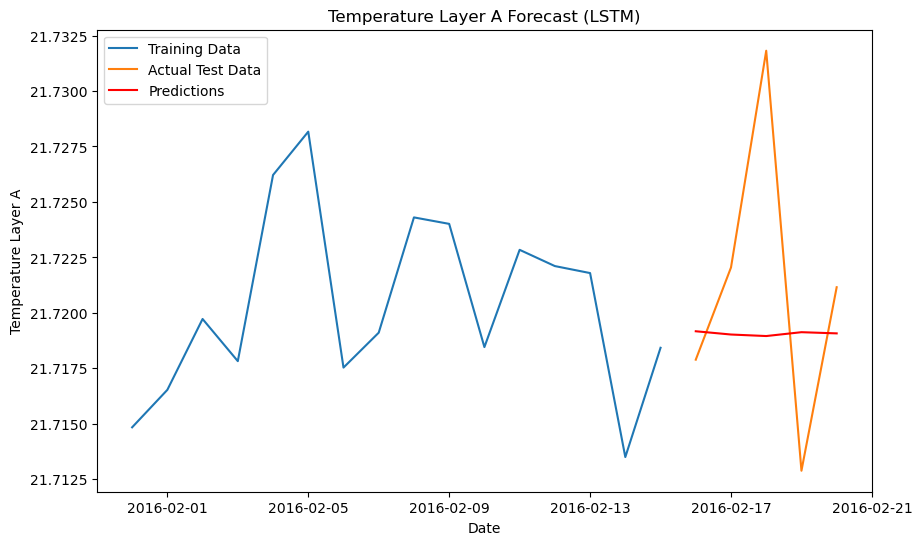

In [9]:
# Prepare data for LSTM
df_lstm = green_resampled[['Timestamp', 'Temperature Layer A']]
df_lstm.set_index('Timestamp', inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_lstm)

# Create sequences for LSTM
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 30  # Use the last 30 days to predict the next day
X, y = create_sequences(scaled_data, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_lstm.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)

# Predict on test data
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Reverse scaling

# Evaluate the model
mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_lstm.index[time_step:train_size + time_step], scaler.inverse_transform(y_train.reshape(-1, 1)), label='Training Data')
plt.plot(df_lstm.index[train_size + time_step:], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Test Data')
plt.plot(df_lstm.index[train_size + time_step:], predictions, label='Predictions', color='red')
plt.title("Temperature Layer A Forecast (LSTM)")
plt.xlabel("Date")
plt.ylabel("Temperature Layer A")
plt.legend()
plt.show()

### Conclusion

The MSE of 0.0000 is suspiciously low and may not reflect the model’s true performance, which is unusual and warrants further investigation. My next step is to verify that the evaluation is performed on a separate test dataset (not the training data).

## 5. Multi-Objective Optimization

In [10]:
# Define the problem (e.g., maximize crop yield, minimize water usage)
def objective(x):
    # Objective 1: Maximize crop yield (negative for minimization)
    f1 = -x[0]
    # Objective 2: Minimize water usage
    f2 = x[1]
    return np.array([f1, f2])

# Define constraints (if any)
def constraint(x):
    # Example constraint: Total resources cannot exceed 100
    return 100 - np.sum(x)

# Bounds for decision variables (e.g., crop yield and water usage)
bounds = [(0, 100), (0, 100)]

# Initial guess
x0 = np.array([50, 50])

# Solve the multi-objective problem
result = minimize(
    lambda x: np.sum(objective(x)),  # Combine objectives into a single scalar
    x0,
    bounds=bounds,
    constraints={'type': 'ineq', 'fun': constraint}
)

# Print results
print("Optimal Solution:")
print(result.x)
print("Objective Values:")
print(objective(result.x))

Optimal Solution:
[1.00000000e+02 4.40536496e-13]
Objective Values:
[-1.00000000e+02  4.40536496e-13]


### Conclusion

The output represents a successful multi-objective optimization result, where the primary objective is prioritized while the secondary objective is minimized. 

## Overall Conclusion

This project demonstrates the application of data science techniques (Time-Series Analysis and Multi-Objective Optimization)to optimize farming operations and improve agricultural efficiency. By leveraging historical sensor data and advanced algorithms, the project addresses two critical aspects of modern agriculture: predicting plant growth and balancing competing objectives such as maximizing crop yield while minimizing resource usage.